In [1]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = "datasets/HPA_challenge_2018/"
# data_path = Path(PATH)

#### CV generation via sklearn, Multilabel implementation by trent-b, or FastAi

Both libraries seem to be completely useless... can just use native fastai function: get_cv_idxs().<br>
However, get_cv_idxs() does NOT shuffle...!

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_label_stratified_CV_idxs(csv_path):
    
    _all_labels = pd.read_csv(csv_path)
    arr = _all_labels.values

    X = arr[:,0]
    y = arr[:,1:]
    
    ### sklearn.model_selection.StratifiedKFold
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    
    for train_index, val_index in sss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    print(f"""Train label-distribution:\n"""
          f"""{pd.Series(arr[:,1][trn_idxs]).value_counts()}""")
    print(f"""Val label-distribution:\n"""
          f"""{pd.Series(arr[:,1][val_idxs]).value_counts()}""")
    
    return trn_idxs, val_idxs


from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def get_label_stratified_CV_idxs_multi(csv_path):
    
    # FastAi csv_source expects a folder-name string to be passed as first arg... -> 'dummy'
    X, y, all_lbls = csv_source('dummy', csv_path)
    
    ### Iterative stratification library: https://github.com/trent-b/iterative-stratification
    msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2)
    
    for train_index, val_index in msss.split(X, y):
        trn_idxs = train_index
        val_idxs = val_index
    
    trn_count = np.sum(y[trn_idxs], axis=0)
    val_count = np.sum(y[val_idxs], axis=0)
    
    print(f"""Train label-distribution:\n"""
          f"""{trn_count}""")
    print(f"""Val label-distribution:\n"""
          f"""{val_count}""")
    
    return trn_idxs, val_idxs

In [5]:
### used atm...
# csv_path = path + 'Kaggle_AND_HPAv18_60x_NoDefDupes_labels.csv'
# trn_idxs, val_idxs = get_label_stratified_CV_idxs(csv_path)

In [6]:
csv_path = path + 'Kaggle_AND_HPAv18_60x_NoDefDupes_labels.csv'
trn_idxs, val_idxs = get_label_stratified_CV_idxs_multi(csv_path)

Train label-distribution:
[30930.  2163.   126.  1627.  1626.  1040.  1930.    46.   894.   325.  1403.  2714.  8046.   307. 10262.
  1934.  7611.   329. 28213.   511.    83.  2382.  3576.  4360.  2582.  7022.   142.   127.]
Val label-distribution:
[7733.  541.   31.  407.  406.  260.  483.   12.  223.   81.  351.  678. 2012.   77. 2565.  483. 1903.   82.
 7054.  128.   21.  595.  894. 1090.  646. 1755.   35.   32.]


In [39]:
import pickle

# idxs_dict = {'trn_idxs': trn_idxs, 'val_idxs': val_idxs}

# with open('datasets/HPA_challenge_2018/tmp/dn121_AWS_1_cont_idxs.pkl', 'wb') as handle:
#     pickle.dump(idxs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('datasets/HPA_challenge_2018/tmp/dn121_AWS_1_cont_idxs.pkl', 'rb') as handle:
    idxs_dict_load = pickle.load(handle)
    
val_idxs_loaded = idxs_dict_load['val_idxs']

In [7]:
# setting up a list of a random 20% of images in train as the validation set

# lbl_csv = path + 'Kaggle_AND_HPAv18_60x_NoDefDupes_labels.csv'
# n = len(list(open(lbl_csv))) -1
# val_idxs = get_cv_idxs(n, val_pct=0.2)


# Count labels
# _all_labels = pd.read_csv(PATH + 'multi_folder_Hirano3D_02.csv')
# print(_all_labels.Targets.value_counts())

# _arr = _all_labels.values
# _val_labels = pd.DataFrame(_arr[val_idxs], columns=['Id','Targets'])
# print(_val_labels.Targets.value_counts())

In [8]:
# l = os.listdir('datasets/HPA_challenge_2018/HPAv18_GBRY_60x_def_dupes_removed_all')
# l[0]

In [9]:
!ls datasets/HPA_challenge_2018

HPA_labels.csv				     data
HPAv18RBGY_wodpl.csv			     haystack_no_si.csv
HPAv18_60x_def_dupes_removed.csv	     models
HPAv18_60x_def_dupes_removed_labels.csv      needles.csv
HPAv18_BGRY_source			     sample_submission.csv
HPAv18_BGR_all				     test-raw
HPAv18_BGR_source			     test.zip
HPAv18_def_dupes_removed.csv		     test_BGR_all
HPAv18_dupes_400.csv			     test_BGYR_all
HPAv18_dupes_5k.csv			     tmp
HPAv18_dupes_no_si_dist5.csv		     train.csv
HPAv18_dupes_no_si_dist5.pkl		     train.zip
HPAv18_dupes_no_si_phash_10_BGR.pkl	     train_BGR_all
HPAv18_wodpl_60x.csv			     train_BGYR_all
Kaggle_AND_HPAv18_60x_NoDefDupes_labels.csv  train_raw
Kaggle_HPA_labels.csv


### Define Dataloader:

In [8]:
def get_data(path, lbl_csv, val_idxs, sz, bs, aug_tfms, crp_sz):

    tfms = tfms_with_IntNorm(sz, aug_tfms=aug_tfms, crop_type=CropType.RANDOM, crp_sz=crp_sz)
    data = ImageClassifierData.from_csv(PATH, 'data', lbl_csv, 
                                        val_idxs = val_idxs,
                                        test_name='data/Kaggle_test_GBRY', 
                                        tfms=tfms, bs=bs, suffix = '.tiff', 
                                        balance=True)
    return data

In [9]:
PATH = "datasets/HPA_challenge_2018/"
# data_path = Path(PATH)

In [ ]:
### max-size bs=64

In [24]:
NUM_CLASSES = 28
bs = 128
sz = [4,194,194]

In [25]:
NUM_CLASSES = 28
bs = 128
sz = [4,194,194]

# define augmentations
augs = [RandomDihedral()]

crp_sz = 1360/2056
# csv:
lbl_csv = path + 'Kaggle_AND_HPAv18_60x_NoDefDupes_labels.csv'

# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs, crp_sz=crp_sz)

val_crop is: 1
Calculating weights...
Weights calculated successfully!
Using WeightedRandomSampler


### inpsect data_loaders

In [21]:
x, y = next(iter(data.trn_dl))
im = to_np(x)[0]
im.shape
# x_test, y_test = next(iter(data.test_dl))

(4, 128, 128)

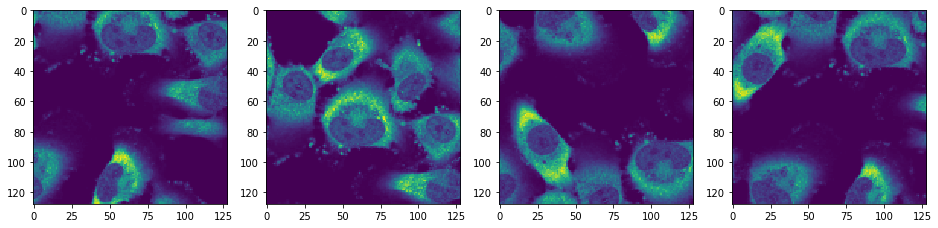

In [23]:
# print transformations
# plt.style.use('seaborn-white')

c = 0
idx = 0
fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
#     ax.imshow(np.sum(im, axis = 0))
    ax.imshow(im[c])

In [ ]:
# loading epoch for manual inspection...

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)


### inpsecting loaded images and labels

In [ ]:
def to_label(y):
    ind = [i for i, p in enumerate(y) if y[i]==1]
    return(ind)

In [ ]:
# inspect train images
plt.style.use('seaborn-white')

idx = 2

im = to_np(x)[idx]

# lbl = to_np(y)[idx]
lbl = to_label(to_np(y)[idx])
print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

In [ ]:
# inspect test images
plt.style.use('seaborn-white')

idx = 3

im = to_np(x_test)[idx]

# lbl = to_label(to_np(y)[idx])
# print(lbl)

fig, ax = plt.subplots(1,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    ax.imshow(im[i])

# training

In [26]:
torch.cuda.is_available()

True

In [10]:
# base-model

arch = dn121_c
# arch = resnet50
learn = ConvLearner.pretrained(arch, data, ps=0, opt_fn=optim.Adam, pretrained=False)

NameError: name 'data' is not defined

In [42]:
# additional parameters

wd=1e-5 # weight-decay/L2 regularization 
learn.metrics = [accuracy_thresh(0.5),f1_macro]

In [43]:
learn.unfreeze()

In [44]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 4, 194, 194]),
                           ('output_shape', [-1, 64, 97, 97]),
                           ('trainable', True),
                           ('nb_params', 12544)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 97, 97]),
                           ('output_shape', [-1, 64, 97, 97]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 97, 97]),
                           ('output_shape', [-1, 64, 97, 97]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 97, 97]),
                           ('output_shape', [-1, 64, 49, 49]),
                           ('nb_params', 0)])),
             ('BatchNorm2d-5',
              OrderedDict([('input_shape', [-1, 64, 49, 49]),
  

In [31]:
learn.lr_find2()

 77%|███████▋  | 470/612 [10:22<02:54,  1.23s/it, loss=0.91] 

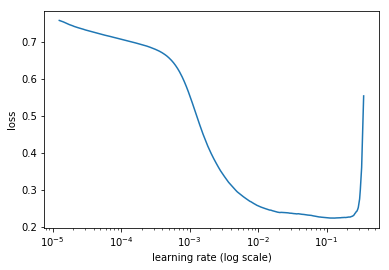

In [32]:
learn.sched.plot()

In [45]:
!ls datasets/HPA_challenge_2018/tmp

In [ ]:
# training loops:

In [47]:
%time learn.fit(1e-3, 5, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 0      
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.169275   0.153856   0.949852   0.144125  
EPOCH 1 ---------------------------------------- STEP 1      
    1      0.14318    0.145707   0.9491     0.1905    
EPOCH 2 ---------------------------------------- STEP 2      
    2      0.123562   0.133642   0.955116   0.227216  
EPOCH 3 ---------------------------------------- STEP 3      
    3      0.114602   0.126275   0.957575   0.254504  
EPOCH 4 ---------------------------------------- STEP 4      
    4      0.101432   0.11845    0.960138   0.283472  
EPOCH 5 ---------------------------------------- STEP 5       
    5      0.091971   0.115577   0.960541   0.30818   
EPOCH 6 ---------------------------------------- STEP 6       
    6      0.084231   0.109407   0.962999   0.323825  
EPOCH 7 ---------------------------------------- STEP 7       
    7      0.076148   0.107313   0.963572   0.34078   
EPOCH

KeyboardInterrupt: 

In [49]:
learn.save('HPAv18_bs128_sz128_rCrp_dn121_v1')

In [75]:
!ls datasets/HPA_challenge_2018/logs

epoch_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv
iter_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv


In [74]:
p = learn.sched

_iter_log = [[p.iterations[i], p.losses[i], p.lrs[i]] for i in range(len(p.iterations))]
_epoch_log = [[p.glob_step[i], p.val_losses[i], *p.rec_metrics[i]] for i in range(len(p.glob_step))]

_iter_log = pd.DataFrame(_iter_log, columns=["Iterations", 'trn_oss', 'Lr'])
_epoch_log = pd.DataFrame(_epoch_log, columns=['Global_step','val_loss','metric_1', 'f1_macro'])

# _iter_log.to_csv('datasets/HPA_challenge_2018/logs/iter_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv', index=False) 
_epoch_log.to_csv('datasets/HPA_challenge_2018/logs/epoch_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv', index=False)

In [ ]:
### increasing image size

In [56]:
val_idxs = val_idxs
bs = 64
sz = [4,388,388]
# augs = [RandomDihedral()]
crp_sz = 1360/2056
# lbl_csv = path + 'Kaggle_AND_HPAv18_60x_NoDefDupes_labels.csv'

# initialize data object
data_256 = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs, crp_sz=crp_sz)

val_crop is: 1
Calculating weights...
Weights calculated successfully!
Using WeightedRandomSampler


In [57]:
learn.set_data(data_256)

In [59]:
x, y = next(iter(data_256.trn_dl))
im = to_np(x)[0]
im.shape

(4, 256, 256)

In [78]:
learn.data.b

64

In [79]:
%time learn.fit(1e-3, 2, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 26        
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.093004   0.112379   0.961284   0.27981   
 36%|███▌      | 442/1224 [06:07<09:11,  1.42it/s, loss=0.0884]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



EPOCH 1 ---------------------------------------- STEP 27        
    1      0.081448   0.108733   0.96301    0.293646  
EPOCH 2 ---------------------------------------- STEP 28        
    2      0.074645   0.10759    0.963654   0.300353  
  4%|▍         | 50/1224 [00:46<13:32,  1.45it/s, loss=0.0739] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



EPOCH 3 ---------------------------------------- STEP 29        
    3      0.071431   0.105926   0.963788   0.306179  
 70%|██████▉   | 854/1224 [12:10<04:16,  1.44it/s, loss=0.066] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



EPOCH 5 ---------------------------------------- STEP 31        
    5      0.063692   0.105927   0.964191   0.309601  
 36%|███▋      | 446/1224 [05:51<08:58,  1.44it/s, loss=0.0621]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



EPOCH 7 ---------------------------------------- STEP 33        
    7      0.058763   0.105625   0.964353   0.313844  
EPOCH 8 ---------------------------------------- STEP 34        
    8      0.064166   0.110851   0.962629   0.307794  
EPOCH 9 ---------------------------------------- STEP 35        
    9      0.062419   0.11014    0.962716   0.304459  
EPOCH 10 ---------------------------------------- STEP 36       
    10     0.060057   0.108592   0.963799   0.307822  
EPOCH 11 ---------------------------------------- STEP 37       
    11     0.056761   0.107817   0.963983   0.310358  
EPOCH 12 ---------------------------------------- STEP 38       
    12     0.055258   0.108245   0.964003   0.313806  
EPOCH 13 ---------------------------------------- STEP 39       
    13     0.052975   0.108285   0.964042   0.31366   
EPOCH 14 ---------------------------------------- STEP 40       
    14     0.050738   0.106623   0.96438    0.315856  
EPOCH 15 -------------------------------

[array([0.1072]), 0.9645743200778476, 0.3158707497022124]

In [80]:
learn.save('HPAv18_bs128_sz128_rCrp_dn121_v2')

In [81]:
p = learn.sched

_iter_log = [[p.iterations[i], p.losses[i], p.lrs[i]] for i in range(len(p.iterations))]
_epoch_log = [[p.glob_step[i], p.val_losses[i], *p.rec_metrics[i]] for i in range(len(p.glob_step))]

_iter_log = pd.DataFrame(_iter_log, columns=["Iterations", 'trn_oss', 'Lr'])
_epoch_log = pd.DataFrame(_epoch_log, columns=['Global_step','val_loss','metric_1', 'f1_macro'])

_iter_log.to_csv('datasets/HPA_challenge_2018/logs/iter_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv', header=False, index=False, mode='a') 
_epoch_log.to_csv('datasets/HPA_challenge_2018/logs/epoch_log_HPAv18_bs128_sz128_rCrp_dn121_v1_.csv', header=False, index=False, mode='a')

In [82]:
%time learn.fit(5e-4, 2, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 42        
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.053261   0.108477   0.964195   0.316288  
EPOCH 1 ---------------------------------------- STEP 43        
    1      0.05109    0.111767   0.963202   0.316088  
appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/
CPU times: user 1h 5min 45s, sys: 26min 7s, total: 1h 31min 52s
Wall time: 42min 17s


[array([0.11177]), 0.9632020869083486, 0.31608765035957964]

In [ ]:
############## CONTINUED -> 64_256

In [13]:
val_idxs = val_idxs
bs = 64
sz = [4,388,388]
augs = [RandomDihedral()]
crp_sz = 1360/2056
lbl_csv = path + 'Kaggle_AND_HPAv18_60x_NoDefDupes_labels.csv'

# initialize data object
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, aug_tfms = augs, crp_sz=crp_sz)

val_crop is: 1
Calculating weights...
Weights calculated successfully!
Using WeightedRandomSampler


In [14]:
# base-model

arch = dn121_c
# arch = resnet50
learn = ConvLearner.pretrained(arch, data, ps=0, opt_fn=optim.Adam, pretrained=False)

In [16]:
wd = 1e-10

In [17]:
learn.load('HPAv18_bs128_sz128_rCrp_dn121_v2')

In [20]:
learn.metrics = [accuracy_thresh(0.5),f1_macro]

In [21]:
%time learn.fit(10e-4, 4, cycle_len=8, wds=wd, use_wd_sched=True, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 4         
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.056554   0.092614   0.967002   0.355984  
EPOCH 1 ---------------------------------------- STEP 5         
    1      0.057021   0.092942   0.966979   0.357819  
EPOCH 2 ---------------------------------------- STEP 6         
    2      0.055482   0.094388   0.966628   0.356541  
EPOCH 3 ---------------------------------------- STEP 7         
    3      0.050852   0.093126   0.967123   0.361674  
EPOCH 4 ---------------------------------------- STEP 8         
    4      0.05125    0.092188   0.967101   0.359066  
EPOCH 5 ---------------------------------------- STEP 9         
    5      0.04756    0.093428   0.967013   0.363021  
EPOCH 6 ---------------------------------------- STEP 10        
    6      0.047767   0.09215    0.967539   0.360882  
EPOCH 7 ---------------------------------------- STEP 11        
    7      0.043934   0.090242   0.9682

KeyboardInterrupt: 

In [24]:
learn.save('HPAv18_bs64_sz256_rCrp_dn121_v2_2_val_009')

In [25]:
p = learn.sched

_iter_log = [[p.iterations[i], p.losses[i], p.lrs[i]] for i in range(len(p.iterations))]
_epoch_log = [[p.glob_step[i], p.val_losses[i], *p.rec_metrics[i]] for i in range(len(p.glob_step))]

_iter_log = pd.DataFrame(_iter_log, columns=["Iterations", 'trn_oss', 'Lr'])
_epoch_log = pd.DataFrame(_epoch_log, columns=['Global_step','val_loss','metric_1', 'f1_macro'])

_iter_log.to_csv('datasets/HPA_challenge_2018/logs/iter_log_HPAv18_bs64_sz256_rCrp_dn121_v2_2_val_009.csv', header=False, index=False) 
_epoch_log.to_csv('datasets/HPA_challenge_2018/logs/epoch_log_HPAv18_bs64_sz256_rCrp_dn121_v2_2_val_009.csv', header=False, index=False)

In [26]:
%time learn.fit(1e-4, 4, wds=wd, use_wd_sched=True)

EPOCH 0 ---------------------------------------- STEP 30        
epoch      trn_loss   val_loss   <lambda>   f1_macro   
    0      0.041531   0.098023   0.966535   0.352735  
EPOCH 1 ---------------------------------------- STEP 31        
    1      0.039665   0.09744    0.96669    0.352213  
EPOCH 2 ---------------------------------------- STEP 32        
    2      0.039074   0.097163   0.96705    0.355428  
EPOCH 3 ---------------------------------------- STEP 33        
    3      0.03935    0.097243   0.966907   0.350807  
appending existing log-files...
log-files saved to: datasets/HPA_challenge_2018/
CPU times: user 2h 8min 23s, sys: 1h 5min 23s, total: 3h 13min 47s
Wall time: 1h 34min 37s


[array([0.09724]), 0.9669073318067954, 0.3508065315458333]

## test-predictions

In [ ]:
log_preds, y = learn.predict_with_targs()
preds = np.argmax(log_preds, axis=1)
print(preds)

In [ ]:
log_preds, y =  learn.TTA()

In [ ]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [ ]:
log_preds, y =  learn.TTA(is_test=True)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
print(preds)

In [43]:
# function to be called by register_forward_hook

def get_embeddings(layer_name):
    def register_hook(layer_name):
        def get_embedding(layer, inp, outp):
            tmp = inp[0]
            embedding.append(tmp)

        hook = layer.register_forward_hook(get_embedding) 
        
        for i in ['trn', 'val', 'test']:
            embedding = []
            preds, y = learn.predict_with_targs(i)
            
            # populating dict, consiting of [0]: preds, [1]: y, [2]: activations[layer]
            embeddings[i] = [preds, y, np.vstack(to_np(embedding))]
            
        hook.remove()
        
    embeddings = {}    
    layer = learn.models.model._modules.get(layer_name)
    register_hook(layer)
    
    return embeddings

In [44]:
embeddings = get_embeddings('7')

In [ ]:
!ls datasets/HPA_challenge_2018/tmp/ 

In [45]:
import pickle

with open('datasets/HPA_challenge_2018/tmp/Embeddings_HPAv18_bs64_sz256_rCrp_dn121_v2_2_val_009.pkl', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('datasets/HPA_challenge_2018/tmp/Embeddings_HPAv18_bs64_sz256_rCrp_dn121_v2_2_val_009.pkl', 'rb') as handle:
    embeddings_loaded = pickle.load(handle)
    
# embeddings = embeddings_loaded

In [47]:
# unpacking embeddings

embs_trn = embeddings['trn'][2]
y_trn = embeddings['trn'][1]

embs_val = embeddings['val'][2]
y_val = embeddings['val'][1]

embs_test = embeddings['test'][2]
y_test = embeddings['test'][1]

print(embs_trn.shape)
print(embs_val.shape)
print(embs_test.shape)

print(y_trn.shape)
print(y_val.shape)
print(y_test.shape)


(78443, 512)
(19549, 512)
(11702, 512)
(78443, 28)
(19549, 28)
(11702,)


In [30]:
import umap

ModuleNotFoundError: No module named 'umap'

In [31]:
UMAP_trn_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.3,
                      metric='correlation').fit(embs_trn)

UMAP_trn = UMAP_trn_embedding.embedding_
UMAP_val = UMAP_trn_embedding.transform(embs_val)
UMAP_test = UMAP_trn_embedding.transform(embs_test)

NameError: name 'umap' is not defined

In [ ]:
# data.test_ds.fnames

In [ ]:
y_test = np.zeros(60)
y_test[:30] = y_test[:30] +1 
y_test

In [ ]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

compA = 0
compB = 1

for i in range(4):
    trn_UMAP_cls = UMAP_trn[y_trn == i]

    axarr[0].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)
    axarr[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    if i == 0:
        axarr[1].scatter(trn_UMAP_cls[:,compA], trn_UMAP_cls[:,compB], label = data.classes[i], s = 5)

    axarr[0].set_xlim(-10,5)
    axarr[0].set_ylim(-5,8)
    
for i in [0,1]:
    test_UMAP_cls = UMAP_test[y_test == i]
    
    axarr[1].scatter(test_UMAP_cls[:,compA], test_UMAP_cls[:,compB], s = 5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axarr[1].set_xlim(-10,5)
    axarr[1].set_ylim(-5,8)


In [48]:
def opt_th(preds, targs, start=0.2, end=0.6, step=0.05):
    ths = np.arange(start,end,step)
    res = [f1_macro(preds, targs, thresh=th, kind='macro') for th in ths]
    idx = np.argmax(res)
    return ths[idx], res

In [49]:
# get train predictions

preds_trn, targs_trn =  learn.predict_with_targs('trn')

preds_trn_torch = torch.from_numpy(preds_trn)
targs_trn_torch = torch.from_numpy(targs_trn)

opt_th(preds_trn_torch, targs_trn_torch)

(0.39999999999999997,
 [0.9111186541763866,
  0.9182067707522008,
  0.9227271959396349,
  0.9251343173937557,
  0.9256754612324135,
  0.9250973069085475,
  0.9232701449032462,
  0.9199491929069142])

In [ ]:
print(preds_val_torch[0])
print(preds_trn_torch[0])

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)

In [50]:
# get val predictions

preds_val, targs_val =  learn.predict_with_targs('val')

preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

(0.5499999999999999,
 [0.5584885716492323,
  0.5715781970909111,
  0.582753781517366,
  0.5914980077617678,
  0.5991040265889223,
  0.603276364783101,
  0.6064199687451763,
  0.6089739555800765])

In [60]:
# get val predictions

preds_val, targs_val =  learn.TTA(n=8)
preds_val= np.mean(preds_val, axis=0)
preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

(0.44999999999999996,
 [0.5894241000188489,
  0.6117310031185957,
  0.6291668531123685,
  0.6380859270005308,
  0.6429056633027687,
  0.6448453559089005,
  0.6432838636341709,
  0.6408429929200858])

In [62]:
# get val predictions

preds_val, targs_val =  learn.TTA(8)
preds_val= np.mean(preds_val, axis=0)
preds_val_torch = torch.from_numpy(preds_val)
targs_val_torch = torch.from_numpy(targs_val)

opt_th(preds_val_torch, targs_val_torch)

(0.39999999999999997,
 [0.5999948326009479,
  0.6206053930783736,
  0.6360012301152068,
  0.6480159963063173,
  0.6560145983048198,
  0.6556881122323143,
  0.6522553249372819,
  0.6495247135588668])

In [ ]:
# get test predictions

preds_test, targs_test =  learn.predict_with_targs('test')

In [ ]:
targs_test[:50]

In [ ]:
def load_epoch(dl = data.trn_dl):
    
    batch = iter(dl)

    xs = []
    ys = []

#     for b in range(0,len(dl)):
    for b in range(0,10):

        x_, y_ = next(batch)
        x_np, y_np = to_np(x_), to_np(y_)
        xs.append(x_np)
        ys.append(y_np)

    return np.vstack(xs), np.concatenate(ys)

In [ ]:
data.test_dl.sampler

In [ ]:
test_names = data.test_ds.fnames
test_names[:10]

In [ ]:
def create_submission(preds_file, output_name, th = 0.3, TTA=False):
    
    # creating submission file
    
    if TTA:
        preds = preds_file.mean(axis=0)
        print('TTA:',preds.shape)
    else: preds = preds_file
    
    clss = np.arange(0, len(data.classes)) # get class indeces
    res = np.array([' '.join(np.char.mod('%d', clss[np.where(p > th)])) for p in preds]) # generating output

    # ensure that there are no empty cells: in case no value > thresh, fill in with argmax()
    for i in range(res.shape[0]):
        if res[i] == '':
            res[i] = preds[i].argmax()

    # getting image Ids
    fnames = np.array([os.path.basename(im).split('.')[0] for im in data.test_ds.fnames])

    # creating submission file
    sub_df = pd.DataFrame(res, index=fnames, columns=['Predicted'])
    sub_df.to_csv(output_name, index_label='Id')

In [ ]:
submission_name = PATH + 'submissions/Res18_pre_0.42_t-03.csv'

create_submission(log_preds, submission_name, th=0.3, TTA=True)

## other stuff

In [ ]:
# List of label identities:

cell_location_label = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [ ]:
# from sklearn.metrics import f1_score

# thresholds = np.linspace(0, 1, 1000)
# score = 0.0
# test_threshold=0.5*np.ones(28)
# best_threshold=np.zeros(28)
# best_val = np.zeros(28)
# for i in range(28):
#     for threshold in thresholds:
#         test_threshold[i] = threshold
#         max_val = np.max(preds_y)
#         val_predict = (preds_y > test_threshold)
#         score = f1_score(valid_y > 0.5, val_predict, average='macro')
#         if score > best_val[i]:
#             best_threshold[i] = threshold
#             best_val[i] = score
#     print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
#     test_threshold[i] = best_threshold[i]
# print("Best threshold: ")
# print(best_threshold)
# print("Best f1:")
# print(best_val)